# A Tutorial on Neural Networks

In this tutorial, we're going to translate some of the concepts that we've been talking about in the lecture part into code. 

**Advanced Exercise** (to do at home): it is really, really instructive to write your own code implement and train a neural network, including the backpropagation and gradient descent. I highly encourage you to do so, for your own understanding of the subject matter. However, this would take more time than we have today, so today we'll use an existing library.

### Neural Network Libraries

There are basically two major libraries for neural networks: [tensorflow](https://www.tensorflow.org) (designed and supported by Google) and [torch](http://torch.ch) (originally used by the Facebook AI Research group). These libraries realistically underpin the vast majority of neural network-based machine learning applications today. A third open-source library, theano, existed, but has been moved to the [aesara](https://github.com/aesara-devs/aesara) project and is primarily maintained to support a probabilistic modeling package called [pymc3](https://docs.pymc.io/en/v3/) (check it out! it's very cool!). 

Which package you use depends, to some extent, on personal preference. While I mentioned above that you should absolutely try two write your own basic implementation of a  neural network, I probably wouldn't suggest to use it for actual research (or other) applications. Both tensorflow and torch are well-supported packages that are heavily optimized to make training neural networks fast and efficient. 

Both tensorflow and torch contain lower-level functionality that underpins a lot of the clever optimization. One of them is high-performance numerical computing (e.g. with the [JAX](https://jax.readthedocs.io/en/latest/#) library). Similarly, there are higher-level layers built on top of tensorflow and torch that make model-building in practice a lot easier and more efficient. Of particular interest to you might be [keras](https://keras.io), which is built on top of tensorflow, and [pytorch](https://pytorch.org), which provides a python interface layer to torch. 

Traditionally, Bayesian inference is really hard because the posterior is usually analytically intractable, and methods to approximate it are often slow and computationally expensive. There has been a recent push to make some of the infrastructure and insights of building efficient machine learning algorithms for probabilistic inference, and there are now some relatively new packages that implement some of these new ideas. PyMC3, as mentioned above, has been doing this for a long time, but is now joined by [edward2](https://github.com/google/edward2) (built on tensorflow) and [pyro](http://pyro.ai) (built on torch). 

### Imports

Today, we'll use PyTorch to build neural networks and train them. So let's start with some imports:

In [1]:
# some plotting stuff
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

## PyTorch Imports ##

# general PyTorch library
import torch
# neural network subpackage
from torch import nn
# data loading functionality
from torch.utils.data import DataLoader

# import example dataset
from torchvision import datasets

# we basically always need numpy :)
import numpy as np

We'll also load some pre-designed operations that transform data sets into something that might be easier to understand for machine learning algorithms:

In [2]:
from torchvision.transforms import ToTensor, Lambda, Compose

## GPU Support

Machine learning libraries (and machine learning algorithms) really shine if you can run them on GPUs, particulary the powerful GPUs designed for deep learning. This requires installation of PyTorch with GPU support, specifically with the CUDA toolkit and NVIDIA's GPUs. We unfortunately don't have them available for this school, but keep in mind that if you can, running on the GPU may speed up your code considerably.

You can check whether your PyTorch was installed with CUDA support via this command:

In [3]:
torch.cuda.is_available()

False

## PyTorch Nitty-Gritty Tensor Basics

Before we get to learning, we'll have to briefly talk about some of the PyTorch-specific objects first. In particular, a lot of PyTorch is based on it's own `Tensor` object. Think of `Tensor` objects as similar to `numpy.ndarray`s, but optimized to be optimized for efficient Linear Algebra operations on GPUs. 

Let's show some elementary operations, and compare them to its numpy equivalents. To give credit: A lot of this material comes from some of the basic [PyTorch tutorials](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html), which are a great resource for learning how to use the library. I'd highly recommend checking them out!

Let's make a 2-dimensional array (basically a matrix) and turn it into both a numpy array and a `Tensor`:

In [4]:
x = [[1, 2, 3], [4, 5, 6], [7,8,9]]

In [5]:
x_np = np.array(x)
print(f"x: {x_np}" )
print(f"type of x: {type(x_np)}")

x: [[1 2 3]
 [4 5 6]
 [7 8 9]]
type of x: <class 'numpy.ndarray'>


In [6]:
x_to = torch.tensor(x)
print(f"x: {x_to}")
print(f"type of x: {type(x_to)}")

x: tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
type of x: <class 'torch.Tensor'>


PyTorch supports many basic operations, including arithmetic, matrix manipulation, linear algebra and others, similar to numpy, except you can run it on the GPU. 

Be aware that by default, `torch.Tensor` objects are created on the *CPU*, even if you've checked that GPU support is available. You still need to move it to the GPU explicitly to perform operations. Here's how you'd do that (note that for us, the command won't do anything):

In [7]:
if torch.cuda.is_available():
    x_to = x_to.to("cuda")

You can check the device of your tensor like this:

In [8]:
x_to.device

device(type='cpu')

Here are some things we can do with tensors.

Arithmetic operations:

In [9]:
y_to = torch.tensor([[11, 12, 13], [14, 15, 16], [17,18,19]])

In [10]:
x_to + y_to

tensor([[12, 14, 16],
        [18, 20, 22],
        [24, 26, 28]])

Matrix multiplication can be performed in a number of different ways:

In [11]:
z = x_to @ y_to.T
print(z)

tensor([[ 74,  92, 110],
        [182, 227, 272],
        [290, 362, 434]])


In [12]:
z = x_to.matmul(y_to.T)
print(z)

tensor([[ 74,  92, 110],
        [182, 227, 272],
        [290, 362, 434]])


Note that the `*` is used for *element-wise* multiplication:

In [13]:
z = x_to * y_to
print(z)

tensor([[ 11,  24,  39],
        [ 56,  75,  96],
        [119, 144, 171]])


You can achieve the same result using the `mul` operator:

In [14]:
z = x_to.mul(y_to)

Like `numpy`, `pytorch` has some functionality to draw random numbers, or to generate tensors of a certain size populated with ones or zeros:

In [15]:
# draw random numbers between 0 and 1
r = torch.rand((4, 4))
print(r)

tensor([[0.8191, 0.1390, 0.2243, 0.0879],
        [0.7794, 0.0636, 0.7388, 0.6251],
        [0.2823, 0.5857, 0.5019, 0.0840],
        [0.5067, 0.1153, 0.3408, 0.6197]])


In [16]:
# populate an array of size (2,3) with zeros
z = torch.zeros((2,3))
print(z)
print(z.shape)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
torch.Size([2, 3])


In [17]:
# populate an array of size (2,6) with ones
o = torch.ones((2,6))
print(o)
print(o.shape)

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])
torch.Size([2, 6])


In [18]:
# populate an array of size (3,2) with random normal numbers
r = torch.randn((3,2))
print(r)
print(r.shape)

tensor([[-0.8403, -0.5158],
        [-3.1145,  0.7232],
        [-0.9029,  1.1718]])
torch.Size([3, 2])


You can transfer a torch Tensor to a numpy array like this:

In [19]:
on = o.numpy()
print(on)
print(f"type of on: {type(on)}")

[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
type of on: <class 'numpy.ndarray'>


**Exercise**: 
* make a torch.Tensor of random normal numbers with shape (5,4)
* make a torch.Tensor filles with 1s with shape (4,3)
* matrix multiply those tensors together.
* print out the sum

**Solution**:

In [20]:
x1 = torch.randn((5,4))
x2 = torch.ones((4,3))

x1x2 = x1.matmul(x2)

print(f"Sum: {torch.sum(x1x2)}")

Sum: 25.83948516845703


## Learning Hand-Written Digits

In the lecture, we explored how we might theoretically train a computer to recognize handwritten digits. Let's now explore this in code. The [MNIST Handwritten Digits Database](http://yann.lecun.com/exdb/mnist/) is a great resource to get started: it's a very well-studied, extremely well-curated dataset. It doesn't have a lot of weird data issues and biases that you might encounter in real data sets where you're likely to apply machine learning (as we've seen yesterday, the photo-z data set has quite a few strange quirks). It's a widely used benchmark for machine learning algorithms. As of writing this tutorial, top performance stands at 99.87% (see [this website](https://paperswithcode.com/sota/image-classification-on-mnist)), using a model witih around 1.5 million parameters. Let's see how close we can get today?

Experimenting with the MNIST handwritten digits dataset has the advantage that it helps you understand how the algorithms work, and how different choices affect the classification accuracy. However, you should be aware that it also makes it pretty *easy* to implement and run a neural network and get a good result. In reality, designing, developing, testing and improving machine learning models can be a long, arduous process that requires a lot of creativity, digging into the data and experimentation. Don't get discouraged if you try this on astronomy data and it doesn't work right away!

With that in mind, let's load the MNIST data. PyTorch has a bunch of datasets pre-loaded, which makes things pretty easy.

The first time you run the command below, it will download the requisite data to whatever path you specify in `root`. PyTorch has already helpfully split the training and the test data sets, so we can load them separately by setting `train=True` for the training data set, and `train=False` for the test data set. We'll also have to set `download=True` the first time we run this, but not the next time (if you rerun this notebook).

Note that we can't use the input data as it's being provided, we need to transform both the pixel values of the images, and the labels. Firs, the `ToTensor()` transform moves the data from numpy arrays to pytorch tensors so that PyTorch can use them. Secondly, by default, the labels are stored as numbers from 0 to 9 (i.e. the number that's being displayed on the image). We're going to work with two different cases below. First, we'll look at logistic regression as a *binary* classifier. For this we're just going to answer the question "Is it a 4?". If the answer is "yes", then we'll give that label a value of 1, if it's no, the label will have a value of 0. Later on, we'll look at all of the classes with a different encoding of the labels. We can implement this by using a `Lambda` transform. `lambda` in general is a Python way to encode functions on the fly on a single like without the traditional `def function_name(parameters) ...` type syntax. PyTorch has its own version of that implemented as a transform. 



In [21]:
is_it_a_four = Lambda(lambda y: torch.tensor(1) if y ==4 else torch.tensor(0))

In [22]:
training_data = datasets.MNIST(root="data", train=True, download=False, 
                               transform=ToTensor(), target_transform=is_it_a_four)

/astro/users/dhuppenk/.conda/envs/pytorch/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630815121/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [23]:
test_data = datasets.MNIST(root="data", train=False, download=False, 
                           transform=ToTensor(), target_transform=is_it_a_four)

Let's visualize the data:

<IPython.core.display.Javascript object>


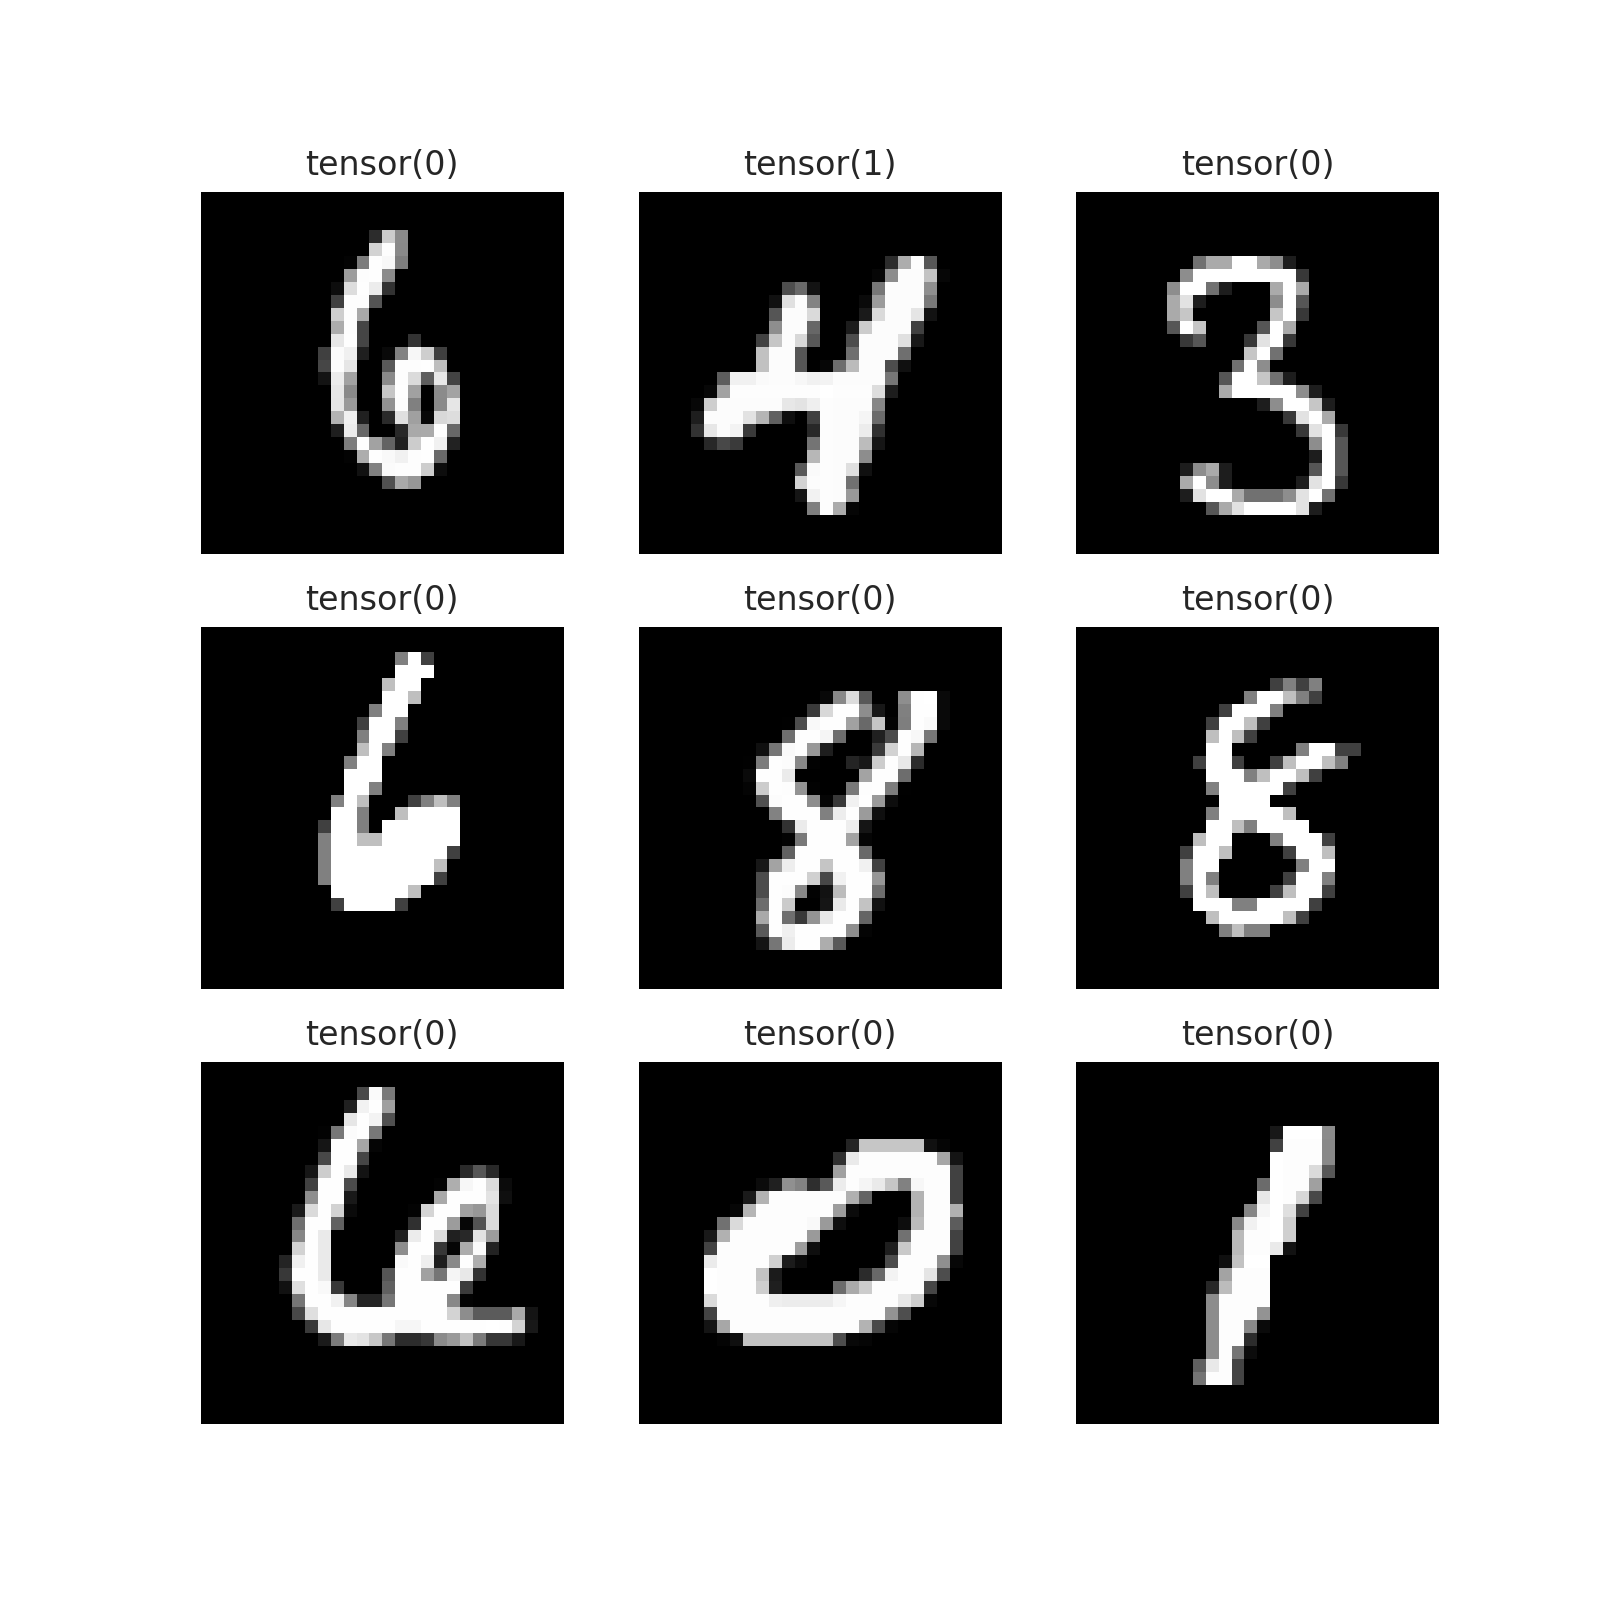

In [24]:
figure = plt.figure(figsize=(8,8))

cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


You can also create custom datasets for your data. We'll go through that process a bit later. We're now ready to build a neural network (woo!).

### Logistic Regression

Let's start simple and build a logistic regression classifier for this problem like we did on the star/galaxy problem yesterday, but this time in PyTorch. Compared to scikit-learn, this will seem very cumbersome, but that's because PyTorch is designed for way more complex things than logistic regression.

In order to build a logistic regression classifier in PyTorch, we need the `torch.nn.Linear` function. This function sets up--perhaps unsurprisingly--a linear model. It takes an `input dimension`, which is the dimension of a single image, if you unfolded it into a vector, and an `output dimension`, which here should be the dimensionality of our labels. 


**Exercise**: 
What should the input and output dimensions be? 
If you don't know, you can check by getting a single training example, turning the image into a vector using `ravel()` and then calculate the length of that vector.


In [25]:
td_sample, td_label = training_data[0]

In [ ]:
input_size = ## ADD YOUR CODE HERE
print(f"Input size: {input_size}")

In [ ]:
output_size =  ## ADD THE NUMBER OF THE OUTPUTS HERE
print(f"Output size: {output_size}")

**Solution**

In [28]:
input_size = td_sample.ravel().shape[0]
print(f"Input size: {input_size}")

Input size: 784


In [29]:
output_size =  1 ## ADD THE NUMBER OF THE OUTPUTS HERE
print(f"Output size: {output_size}")

Output size: 1


So this means we have 784 input values (28 by 28 pixels) and 1 output value, as we'd expect.

In [30]:
linear = torch.nn.Linear(input_size, output_size)

We also need the sigmoid function, which is available from the `torch.nn.functional` module.

There's one more component: we need to stick these commands into a `class`. If you don't know how classes work in Python, don't panic! 

Here's the basic structure for how classes are written in PyTorch (don't execute this cell, because it won't do anything useful; it's just pseudocode to show you the structure):

In [31]:
# you can freely choose the name of the class, but for PyTorch 
# neural network models, you *need* to put `torch.nn.Module` into the 
# brackets
class MyClassName(torch.nn.Module):
    
    # Whatever is in __init__ is run when you call the 
    # class and stick it into a parameter (in programming 
    # speak, you're "creating an object")
    # input parameters is stuff that helps you set up the class
    def __init__(self, input_parameters):
        
        # always call this function `super` with the name 
        #you gave the class
        super(MyClassName, self).__init__()
        
        # here's where the neural network code goes. 
        # we'll talk about that in a bit
        # In short, this is where you can define 
        # crucial pieces of your neural network
        self.stuff = torch.nn.Sequential(...)
        
    def forward(self, x):
        # here is where you put the code that generates 
        # the neural network *predictions* for the label
        # It's called forward because it's used to do
        # a forward pass through the nextwork
        y_pred = run_some_stuff(self.stuff)
        return y_pred

If this looks really confusing, don't worry! It'll hopefully become clear pretty soon.

One thing you might notice is that we've not defined anything to do backpropagation anywhere. That's because we don't need to: PyTorch will do that automatically for us. Hooray! We don't need to worry about all of these indices!

Let's take a look what this class looks like for logistic regression:

In [32]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_size, output_size):
        
        """
        Logistic Regression the hard way, in PyTorch.
        
        Parameters
        ----------
        input_size : int
            The number of features or data points in each sample
        
        output_size : int
            The dimensionality of the outputs (targets) 
        
        """
        
        super(LogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()
        self.lm = torch.nn.Linear(input_size, output_size)
        
    def forward(self, x):
        
        """
        Calculate the predicted targets `y_pred` of the logistic 
        regression given fixed weights, and some input vector 
        of features or data points `x`. 
        
        Parameters
        ----------
        
        x : torch.Tensor
            Feature vector for a single example
            
        Returns
        -------
        
        y_pred : torch.Tensor
            Tensor of the predicted targets.
        
        """
        xflat = self.flatten(x)
        y_pred = self.sigmoid(self.lm(xflat))
        return y_pred

Okay, so what have we done: We've made a class called `LogisticRegression` (while you *can* name your classes anything, you should probably name them something related to the problem that is easy for you to remember), and when you make an object of its type, you will have to pass it in the input dimension of your data (here, 784 pixel values) and the output dimension of the predicted labels (here, 1 value). 

You then define a variable `self.lm` (the "lm" stands for "linear model", and the `self` is important for reasons we won't go into here, but makes it possible that you can call it later in `forward`), which is a linear model with the input size and output size defined by the parameters you gave to that method. This linear model is stored for use in `forward`. 

In that function, you pass in a sample of the (training) data, so that `x` is a single image, unravelled into a vector. This method will then take this function, put it through the linear model, and then squash the entire thing through a sigmoid function. It will then return the output of that function, which should be a value between 0 and 1 and will be our predicted label. And there we go, we have a logistic regression model!

As I said, it looks complicated, but this is the basic framework you can use to start building neural networks. 

Note that you don't see the parameters anywhere. They're implicitly created by Pytorch, but we can look at it after instantiating an object of this class, so let's do that:

In [33]:
model = LogisticRegression(input_size, output_size)

You can take a look at the general structure of the model like this:

In [34]:
print(model)

LogisticRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sigmoid): Sigmoid()
  (lm): Linear(in_features=784, out_features=1, bias=True)
)


In [35]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-3.0413e-02,  2.9100e-02, -2.2262e-02,  4.0231e-03,  9.6252e-03,
          3.0372e-02,  2.2180e-03, -1.0916e-03, -1.8636e-02,  2.1892e-02,
          9.7129e-03, -3.1060e-02,  2.2570e-02, -2.5663e-03,  1.9948e-02,
         -3.2519e-02,  2.8143e-03, -2.3169e-02,  2.2777e-02, -4.0916e-03,
          2.4049e-03,  2.1716e-03, -3.0939e-02, -4.8860e-03,  1.3936e-02,
          2.9320e-02, -1.8126e-02, -4.0283e-03,  3.5397e-02, -6.5155e-04,
          3.2263e-02,  8.7638e-03, -1.8209e-02, -1.4358e-02,  2.5356e-02,
         -2.0399e-02,  8.9375e-03,  1.9107e-02, -1.4848e-02, -2.4153e-02,
         -5.6811e-03,  3.5629e-02, -1.1535e-02, -3.0443e-03, -7.5990e-03,
          3.0084e-02,  2.9220e-02, -2.1331e-02,  3.5568e-02, -2.5654e-02,
          3.7587e-03,  1.0793e-02, -8.4197e-03,  2.1002e-02,  1.3122e-03,
         -1.3726e-02,  1.3783e-02, -1.2243e-02, -1.1898e-02, -1.6883e-02,
          2.8864e-02, -2.3182e-05,  1.6045e-02, -1.3067e-02, -1.8931e-02,
          4.4094

There we go, those are all the weights and the bias. See how both say `requires_grad=True`? PyTorch knows, by default, that we want to calculate the gradients with respect to all of those parameters, which will come in handy later.



Let's take a look at what this predicts for a single image:

In [36]:
t_sample, t_label = training_data[145]
print(f"label: {t_label}")

y_pred = model(t_sample)
print(f"Predicted label: {y_pred}")


label: 0
Predicted label: tensor([[0.5224]], grad_fn=<SigmoidBackward>)


So really, the model is currently not sure. That's not super surprising, because it's been initialized somewhat randomly, so none of the weights have ever seen any of the data and don't know anything about our problem.

In order to make out model learn, we need a cost function.
So let's write one down. For this problem, we're going to pick the Logistic loss we talked about in class, also called the *Binary Cross Entroy Loss*, which is designed for binary problems as we have here (remember, we're currently just figuring out whether any of the images displays a 4 or not):

In [37]:
loss = torch.nn.BCELoss()

Time to do some training! 

For this, we'll need to set three parameters: 
* the learning rate 
* the batch size (remember, we're calculating gradients across mini-batches)
* the epoch (how many passes over the full data we should do.

Let's pick some options (generally, you might want to explore those):

In [38]:
learning_rate = 1e-2 # the learning rate (how raw we step through parameter space)
batch_size = 128 # the size of the mini-batches used for constructing the gradient
epochs = 20 # the number of epochs to train for (1 epoch = one pass through the whole training data set)

We could do the generation of mini-batches by hand, but we don't need to: PyTorch has a convenient structure for this called a `DataLoader`. This structure has the additional advantage that it can dynamically load mini-batches from disk. This is particularly useful when the training dataset might be too large to be loaded into memory all at once. 

Because the training data is pretty big, we're going to pick a subset and just look at those examples to speed up training.

**Important**: If your model still trains really slowly (more than maybe 30 seconds per epoch) come back here and make the training/test data sets even smaller by changing the `15000` and `5000` below to smaller numbers. This'll make the model less accurate, but the point of this exercise is not for you to spend the entire time watching the model slowly train (although that's a pretty accurate description of what you do in this field, too :) ). 

In [39]:
idx_train = torch.randperm(len(training_data))[:15000]
idx_test = torch.randperm(len(test_data))[:5000]

training_data_small = torch.utils.data.Subset(training_data, idx_train)
test_data_small = torch.utils.data.Subset(test_data, idx_test)

In [40]:
train_loader = DataLoader(training_data_small, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data_small, batch_size=batch_size, shuffle=True)

Now we need an optimizer to actually do the minimization of the loss function with respect to the weights. Earlier, we learned about Stochastic Gradient Descent, so let's play around with that. Later on, you'll have the chance to explore others. The optimizer takes the parameters of our `LogisticRegression` model as inputs, as well as the `learning_rate` parameter we defined above, which will give it some idea how far it should step through the space. 

In [41]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In order to do the actual training, we're going to need to loop through all of the mini-batches in our training data. Let's write a function for this to make it easier. The tra

In [42]:
def training_loop(dataloader, model, loss, optimizer):
    # total number of training examples
    n_train = len(dataloader.dataset)
    
    loss_all = []
    
    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)
        y = y.to(torch.float32)
        l = loss(y_pred, torch.unsqueeze(y, dim=1))
        
        # set all gradients to zero
        optimizer.zero_grad()
        
        # do backward propagation through the network
        l.backward()
        
        # let the optimizer take a step through 
        # parameter space with the gradients
        # we just computed
        optimizer.step()
        loss_all.append(l.item())
        
    if batch % 10 == 0:
        l_item = l.item()
        current = batch * len(X)
        print(f"loss : {l_item} [{current} / {n_train}]")
            

    mean_loss = np.mean(loss_all)
        
    return mean_loss

In this function, we loop over all of the mini-batches. For each mini-batch, we compute the loss between the predictions for the current minibatch of training examples and the ground-truth labels of those training examples. Then we set the gradients to zero (this is important!), and do a backward pass through the network to calculate the gradients of the loss function with respect to the parameters. Look how this takes one simple line! 
Finally, we use these gradients to let the optimizer take a step forward.

In the rest of the function we set up some printing to help us diagnose how the optimizer is doing while it's running. We're also going to record all of the losses, so we can plot them later.

Let's write an equivalent function for the test data.

**Important**: in practical applications, you'll probably want to keep the test data secret *to the very end*. That is, you don't use it to check how good your results are until you've done *all* of your neural network explorations and developments. Here, we're going to use it for exploratory purposes. 

In the test loop, we *also* run through our mini-batches, but instead of doing the backward step and optimization, we arejust going to run through the forward pass of the network for each minibatch, and record how well our classifier is doing:

In [43]:
def test_loop(dataloader, model, loss, optimizer):
    # total number of training examples
    n_test = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0 # loss of our test samples
    correct = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            y_pred = model(X)
            y_round = torch.round(y_pred)
            y = y.to(torch.float32)
            test_loss += loss(y_pred, torch.unsqueeze(y, dim=1)).item()
            correct += (y_round == torch.unsqueeze(y, dim=1)).type(torch.float).sum().item()

    test_loss /= num_batches
    corr_frac = correct / n_test
    print(f"Test loss: {test_loss}")
    print(f"Correctly classified samples: {correct}")
    print(f"Accuracy: {corr_frac}")
    return test_loss


Okay, now we're finally ready to run the whole thing:

In [ ]:
train_loss_all, test_loss_all = [], []

# loop over all epochs
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------")
    trl = training_loop(train_loader, model, loss, optimizer)
    tel = test_loop(test_loader, model, loss, optimizer)
    
    train_loss_all.append(trl)
    test_loss_all.append(tel)

Epoch 1
-----------------------
Test loss: 0.24017248563468457
Correctly classified samples: 4496.0
Accuracy: 0.8992
Epoch 2
-----------------------
Test loss: 0.20413600020110606
Correctly classified samples: 4548.0
Accuracy: 0.9096
Epoch 3
-----------------------
Test loss: 0.17591022476553916
Correctly classified samples: 4644.0
Accuracy: 0.9288
Epoch 4
-----------------------
Test loss: 0.15992150334641336
Correctly classified samples: 4721.0
Accuracy: 0.9442
Epoch 5
-----------------------
Test loss: 0.1543704193085432
Correctly classified samples: 4751.0
Accuracy: 0.9502
Epoch 6
-----------------------
Test loss: 0.14049633452668786
Correctly classified samples: 4767.0
Accuracy: 0.9534
Epoch 7
-----------------------
Test loss: 0.1407674191519618
Correctly classified samples: 4787.0
Accuracy: 0.9574
Epoch 8
-----------------------
Test loss: 0.12903344240039588
Correctly classified samples: 4799.0
Accuracy: 0.9598
Epoch 9
-----------------------
Test loss: 0.12323643136769533
Cor

Okay, let's take a look at the training and test losses. It's useful to plot them against the epochs:

<IPython.core.display.Javascript object>


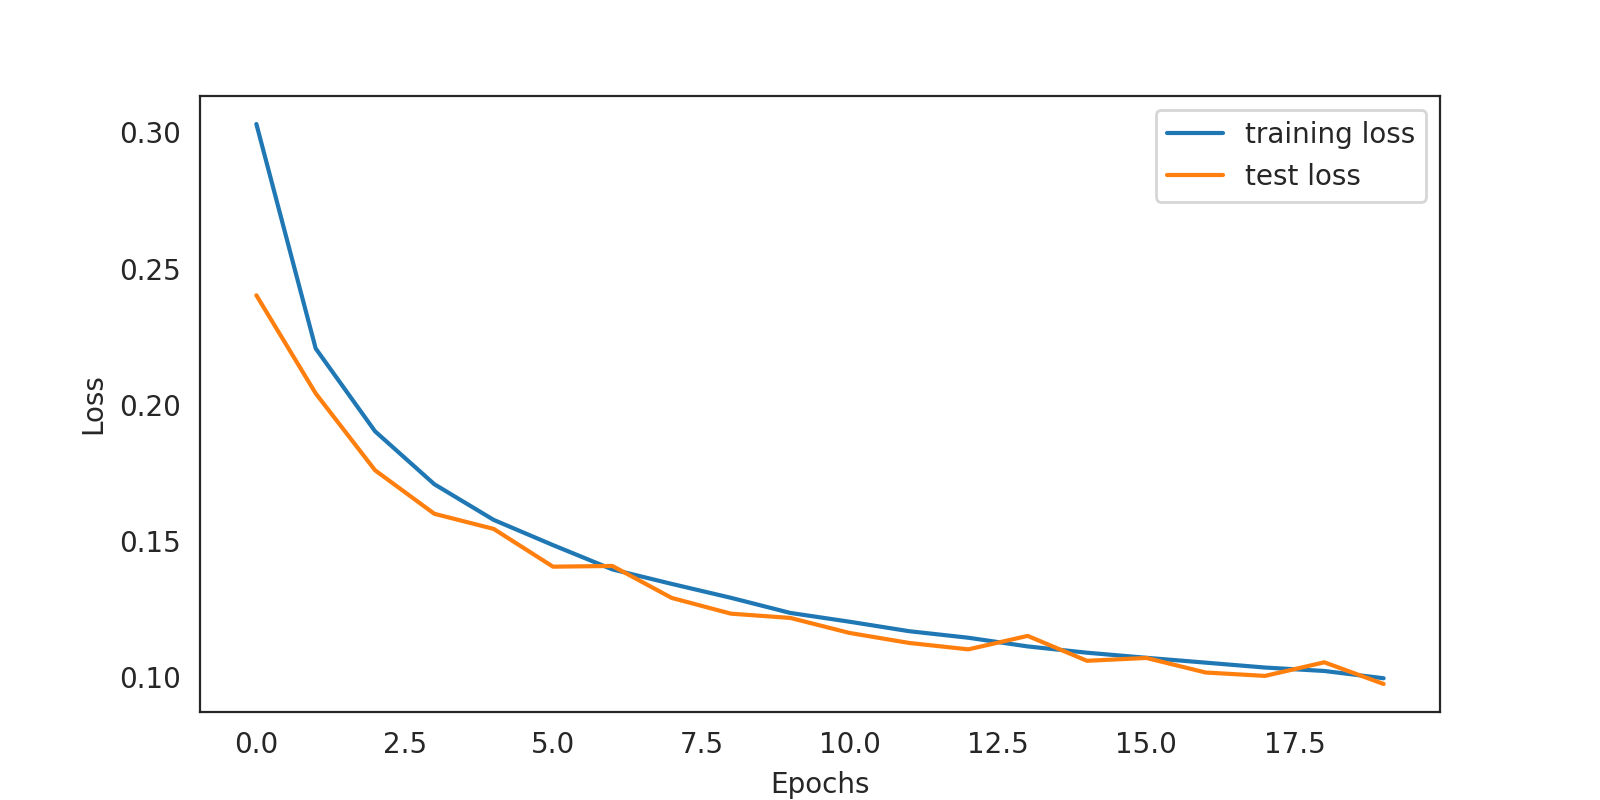

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(np.arange(epochs), train_loss_all, label="training loss")
ax.plot(np.arange(epochs), test_loss_all, label="test loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

That looks like a pretty reasonable curve, with both the training and the test loss decreasing at approximately the same rate. The loss itself isn't very helpful, but thankfully, we also printed out the accuracy above, which, at 97%, is pretty good! 

Let's take a look, though, at the true positive rate and the false negative rate: so we want to know the fraction of all fours that were classified as fours, and also the fraction of fours that were classified as not-fours.

For this, we can run just one iteration of the test loop function:

In [46]:
tel = test_loop(test_loader, model, loss, optimizer)

Test loss: 0.09933654591441154
Correctly classified samples: 4847.0
Accuracy: 0.9694


The total number of correctly classified examples is useful, but we are going to extract all of the predicted labels and also the true labels, and then we're going to use those to find the true positives and the true negatives:

In [48]:
y_pred_all = []
y_true_all = []

with torch.no_grad():
    for X, y in test_loader:
        y_pred = model(X)
        y_round = torch.round(y_pred)
        y_pred_all.extend(y_round)
        y = y.to(torch.float32)
        y_true_all.extend(y)

y_pred_all = torch.hstack(y_pred_all)
y_true_all = torch.hstack(y_true_all)

In [49]:
# true positives are all the samples where we predicted 1 and that have a true label 1
idx_tp = ((y_pred_all == 1) & (y_true_all == 1))
tp = idx_tp.sum()
print(f"The nunber of true positives : {tp}")

# true negatives are all the samples where we predicted 0 and have a true label of 0
idx_tn = ((y_pred_all == 0) & (y_true_all == 0))
tn = idx_tn.sum()
print(f"The number of true negatives : {tn}")


The nunber of true positives : 372
The number of true negatives : 4475


**Exercise**: Similarly to the true positives and true negatives calculates above, calculate the number of false negatives and false positives:

In [ ]:
idx_fp =  # add your code for the false positives here
fp = idx_fp.sum()
print(f"The number of false positives : {fp}")

idx_fn = # add your code for the false negatives here 
fn = idx_fn.sum()
print(f"The number of false negatives : {fn}")

**Solution**:

In [52]:
idx_fp = ((y_pred_all == 1) & (y_true_all == 0))
fp = idx_fp.sum()
print(f"The number of false positives : {fp}")

idx_fn = ((y_pred_all == 0) & (y_true_all == 1))
fn = idx_fn.sum()
print(f"The number of false negatives : {fn}")

The number of false positives : 21
The number of false negatives : 132


We can now combine them to calculat the false positive and false negative rates:

In [53]:
fpr = fp / len(y_true_all)
print(f"The False Positive Rate is {fpr}")

fnr = fn / len(y_true_all)
print(f"The False Negative Rate is {fnr}")

The False Positive Rate is 0.00419999985024333
The False Negative Rate is 0.026399999856948853


This means that only 0.3% of all fours are actually other letters, and about 2% of the fours as classified as not being a four. If this were more than an academic exercise, we'd now look deeper into *which* fours tend to be misclassified, and *which* other letters get classified as a four.

However, the main point of this was to do an (admittedly labour-intensive) version of Logistic Regression in PyTorch. If you think this was way more effort than it needed to be, you would be right! However, it *is* the basis if neural networks, which we're going to tackle next.

## Neural Networks

All right, from here, let's go and take a look at neural networks. We're going to make two immediate changes.

If you remember back to the earlier lecture, the output layer actually consisted of *10 neurons*, one for each number, where the neuron that represented the true number displayed on the image should be 1, and everything else should be zero. Before, we looked only at whether the number on the image is a 4, now we're going to try and see whether we can classify them all together. So for this, we won't implement a `target_transform`, but rather use the labels as is.



In [54]:
training_data = datasets.MNIST(root="data", train=True, download=False, 
                               transform=ToTensor())
test_data = datasets.MNIST(root="data", train=True, download=False, 
                           transform=ToTensor())

Let's visualize these again:

<IPython.core.display.Javascript object>


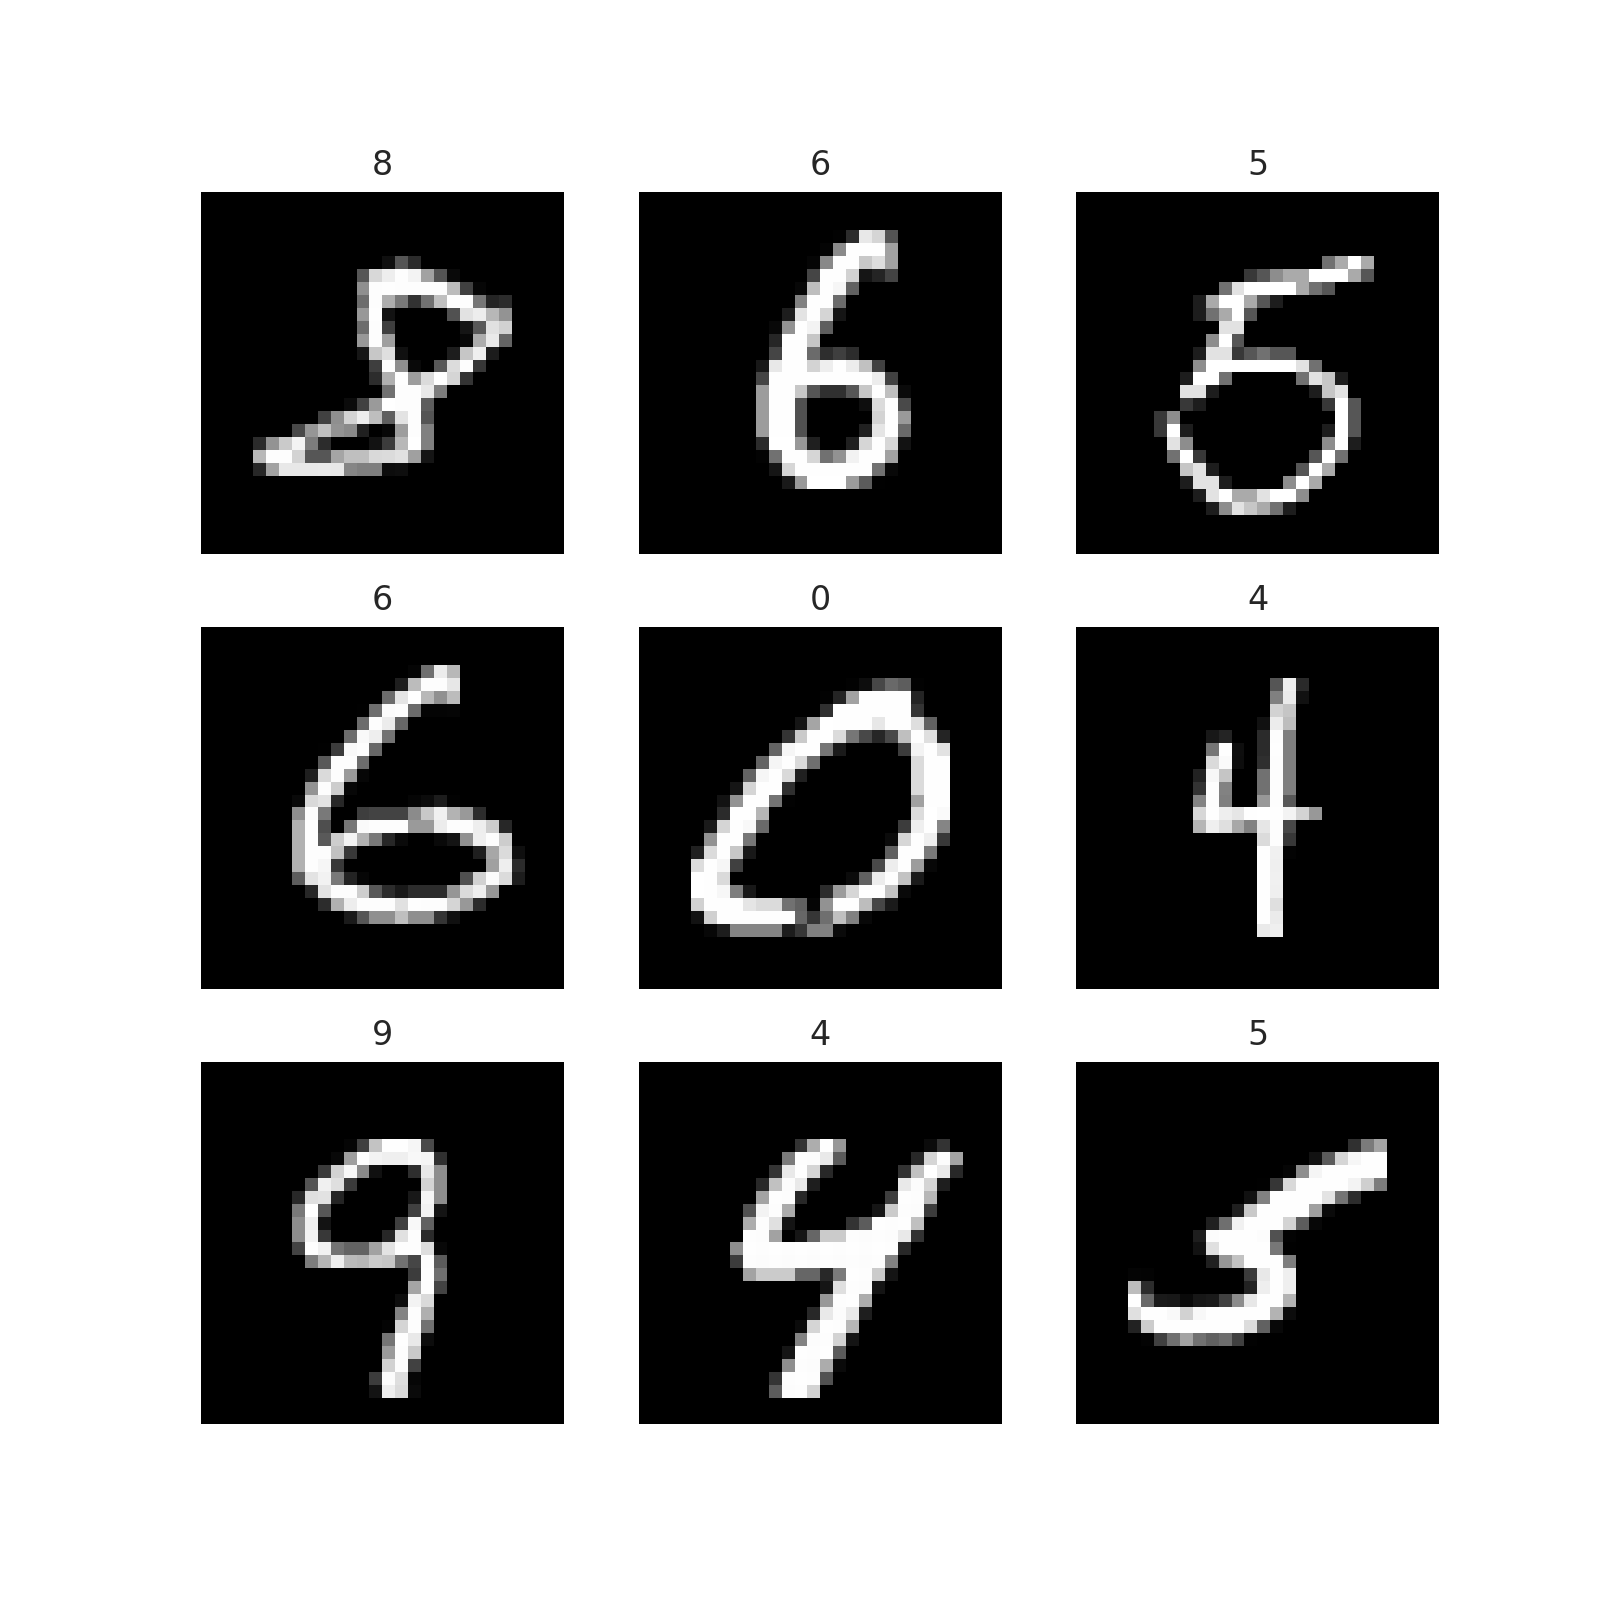

In [55]:
figure = plt.figure(figsize=(8,8))

cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()



We'll need to put these into a `DataLoader` object again:

In [56]:
idx_train = torch.randperm(len(training_data))[:10000]
idx_test = torch.randperm(len(test_data))[:5000]

training_data_small = torch.utils.data.Subset(training_data, idx_train)
test_data_small = torch.utils.data.Subset(test_data, idx_test)

train_loader = DataLoader(training_data_small, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data_small, batch_size=batch_size, shuffle=True)

Now we can take our basic class structure from above, and extend it. We'll also give it a different name, so that we can keep track of the different classes we wrote.

We'll give the output layer 10 elements, and we'll also give it a *hidden layer* of 16 neurons. In Pytorch, you can string layers of neurons together using the `nn.Sequential` function:

In [57]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        A small neural network to classify handwritten digits. 
          
        Parameters
        ----------
        input_size : int
            The number of features or data points in each sample
            
        hidden_size : int
            The number of neurons in the hidden layer
        
        output_size : int
            The dimensionality of the outputs (targets) 

        """

       
        super(NeuralNetwork, self).__init__()
        # this will create a function to flatten the inputs into a 
        # vector
        self.flatten = nn.Flatten()
        
        # stack of layers
        # Linear connections between input and hidden layer, sigmoid,
        # linear connections between hidden layer and output layer
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        # flatten the 2D image into a 1D vector
        xflat = self.flatten(x)
        
        # calculate predictions based on network
        y_pred = self.linear_sigmoid_stack(xflat)
        return y_pred

In the instantiation, we can use our `input_size` variable from earlier (remember, it encoded the size of our input image), but we now have a *new* variable `hidden_size` that encodes the size of the hidden layer, and our `output_size` needs to be 10 to encode our ten different digits:

In [58]:
hidden_size = 16
output_size = 10

In [59]:
model = NeuralNetwork(input_size, hidden_size, output_size)

In [60]:
loss = nn.CrossEntropyLoss()

In [61]:
def training_loop(dataloader, model, loss, optimizer):
    # total number of training examples
    n_train = len(dataloader.dataset)
    
    loss_all = []
    
    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)
#        y = y.to(torch.float32)
        l = loss(y_pred, y)
        
        # set all gradients to zero
        optimizer.zero_grad()
        
        # do backward propagation through the network
        l.backward()
        
        # let the optimizer take a step through 
        # parameter space with the gradients
        # we just computed
        optimizer.step()
        
        loss_all.append(l.item())
        
    if batch % 10 == 0:
        l_item = l.item()
        current = batch * len(X)
        print(f"loss : {l_item} [{current} / {n_train}]")            

    mean_loss = np.mean(loss_all)
        
    return mean_loss

def test_loop(dataloader, model, loss, optimizer):
    # total number of training examples
    n_test = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0 # loss of our test samples
    correct = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            y_pred = model(X)
            #print(y_pred[:5])
#            y = y.]
            #print(y[:5])
            test_loss += loss(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    corr_frac = correct / n_test
            
    print(f"Test loss: {test_loss}")
    print(f"Correctly classified samples: {corr_frac}")
    return test_loss

In [62]:
learning_rate = 0.1
batch_size = 64
epochs = 20
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss_all, test_loss_all = [], []

# loop over all epochs
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------")
    trl = training_loop(train_loader, model, loss, optimizer)
    tel = test_loop(test_loader, model, loss, optimizer)
    
    train_loss_all.append(trl)
    test_loss_all.append(tel)

Epoch 1
-----------------------
Test loss: 2.1017166435718537
Correctly classified samples: 0.5526
Epoch 2
-----------------------
Test loss: 1.7711342692375183
Correctly classified samples: 0.5966
Epoch 3
-----------------------
Test loss: 1.4581010550260545
Correctly classified samples: 0.6864
Epoch 4
-----------------------
Test loss: 1.2214840441942214
Correctly classified samples: 0.7166
Epoch 5
-----------------------
Test loss: 1.0505631163716316
Correctly classified samples: 0.764
Epoch 6
-----------------------
Test loss: 0.927069342136383
Correctly classified samples: 0.807
Epoch 7
-----------------------
Test loss: 0.812520831823349
Correctly classified samples: 0.8332
Epoch 8
-----------------------
Test loss: 0.7361602552235127
Correctly classified samples: 0.8382
Epoch 9
-----------------------
Test loss: 0.6768351532518864
Correctly classified samples: 0.844
Epoch 10
-----------------------
Test loss: 0.6301651135087013
Correctly classified samples: 0.8548
Epoch 11
-----

**Exercise**: Play around with the network and explore how you can improve its performance. 
Things you can try:
* change the learning rate
* change the  batch size
* change the number of neurons in the hidden layer
* change the number of hidden layers: add another! Or two! (but probably not 20, or it'll take forever to train)
* change the activation function: a popular one is the *rectified linear unit*, implemented in `nn.ReLU()`
* change the optimization algorithm. [Here's](https://emiliendupont.github.io/2018/01/24/optimization-visualization/) an example of visualizations of how different optimization algorithms work in different types of problems

You are welcome to explore any of these for the rest of this session: there's plenty to explore here for another week for sure! If you're itching to get started with some astronomy-data, read on below.

### Share your results!

What's the highest accuracy you can get on this problem? Share your best attempt on the [SOSTAT2021 ML leaderboard](https://board.net/p/sostat2021-ml-leaderboard)! How close can you get to the current state-of-the-art results of [99.91%](https://paperswithcode.com/sota/image-classification-on-mnist)?

## A Neural Network for SDSS Photometric Redshifts

Now that you've looked at how to design a neural network for the MNIST data, let's look at some astronomy data:  SDSS photometric redshifts! Getting redshifts for galaxies is both time-consuming and intensive: for far-away galaxies, one might need hours of integration on a spectrograph to get a good enough spectrum redshift estimate. At the same time, large surveys like SDSS and, in the future, LSST, generate *huge* amounts of data of galaxies. However, they only collect *photometric* data: they collect magnitudes in multiple filters. These filters are, in practice, an integral over the multiplication of the underlying spectrum with the filter response. The question is: can we get (good enough) redshifts from these photometric measurements? 

There are different ways to tackle this problem. One is to use *template-matching*. For this, one assumes a physical model for how the combination of stars and other sources in a galaxy generate the emission, and how this emission is redshifted as a function of distance. One can then fit a model that has redshift as a parameter. More complex versions of this type of modelling build sophisticated (Bayesian) statistical models that infer the galaxy properties along with the redshift. There is a strong assumption in this model, though: it assumes that we have a good enough physical model of how the intrinsic emission of galaxies is generated as a function of their evolution that we can generate realistic templates. If the templates are off, our redshifts might also be wrong.

As a response, some researchers have cast this problem into a machine learning problem: take all galaxies for which we *do* have spectroscopic redshifts, and train a machine learning algorithm on the combination of (1) the photometric magnitudes (features), and (2) the spectroscopic redshifts (ground-truth labels). The hope is that this model will generalize enough to new (unseen) examples. Note that it is not clear a priori that this model will do better than a template-matching approach, because it *also* makes strong assumptions. In particular, it assumes that our training data set from current (spectroscopic) surveys is *representative* of the unknown new data we're trying to estimate redshifts for. New telescopes like the Rubin Observatory, which will generate the *Legacy Survey of Space and Time* will look deeper than current surveys, and deeper than most spectroscopic instruments can reasonably integrate to get a good enough spectrum. As a result, training data at high redshifts is very sparse, a problem that the community has worked on for a long time. 

Here, we're going to explore photometric redshift estimation on SDSS data. Note that this is a *regression* task: instead of estimating a discrete class, here you will estimate a *continuous variable*. This means that your last neural network layer should *not* have an activation function. You'll also want to use a cost function that is designed for regression (the Mean Squared Error is a straightforward place to start). 

### Loading the Data

For this, we're going to need to load the data into a format that PyTorch can deal with. To do that, we will have to build our own `DataSet` class. Fear not, I will do this for you here, so that you have a bit of a template for how to possibly do this with your own data.

First, let's get the data:

In [63]:
import pandas as pd

Let's load the SDSS data

In [64]:
data = pd.read_csv("sdss_dataset2.csv")

In [65]:
data.head()

,u,g,r,i,z,class,redshift,redshift_err
0,16.46322,15.49256,15.14610,15.00817,14.83415,GALAXY,0.012641,0.000006
1,17.23730,15.65943,14.76368,14.32308,13.97611,GALAXY,0.086139,0.000017
2,19.26072,17.97265,17.27236,16.88940,16.65260,GALAXY,0.103297,0.000021
3,18.87348,17.84478,17.35933,17.11581,16.95407,GALAXY,0.076046,0.000010
4,18.88721,17.34640,16.52588,16.08977,15.78733,GALAXY,0.075763,0.000009


In [66]:
data.shape

(20000, 8)

In [67]:
spec_z = torch.Tensor(data["redshift"].values)

In [68]:
data = data.drop(["class", "redshift", "redshift_err"], axis=1)

**Exercise**: Prepare this data for the training process. For this, you'll want to
* plot the features
* decide whether you need to apply some data cleaning or not
* create some additional features: the colours (i.e. difference between adjacent filters)

Before you go to the next step, you need to turn the pandas DataFrame into a torch Tensor (see code below for how to do this:
* split the data into a training and a test set using scikit-learn's `train_test_split`
* split the training data set *again* into a training and validation set with the same function
* train the scikit-learn `StandardScaler` on the training data, and then apply it to training, validation and test sets.

**Solution**:

In [69]:
data.head()

,u,g,r,i,z
0,16.46322,15.49256,15.14610,15.00817,14.83415
1,17.23730,15.65943,14.76368,14.32308,13.97611
2,19.26072,17.97265,17.27236,16.88940,16.65260
3,18.87348,17.84478,17.35933,17.11581,16.95407
4,18.88721,17.34640,16.52588,16.08977,15.78733


In [70]:
data["ug_color"] = data["u"] - data["g"]
data["gr_color"] = data["g"] - data["r"]
data["ri_color"] = data["r"] - data["i"]
data["iz_color"] = data["i"] - data["z"]

In [71]:
data.shape

(20000, 9)

Here's how you turn your pandas DataFrame into a torch.Tensor:

In [72]:
data = torch.Tensor(np.array(data))

In [73]:
data.shape

torch.Size([20000, 9])

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
X_train, X_test, z_train, z_test = train_test_split(data, spec_z, test_size=0.15)

In [76]:
X_train.shape

torch.Size([17000, 9])

In [77]:
X_test.shape

torch.Size([3000, 9])

In [78]:
X_train, X_val, z_train, z_val = train_test_split(X_train, z_train, test_size=0.20)

In [79]:
X_train.shape

torch.Size([13600, 9])

In [80]:
X_val.shape

torch.Size([3400, 9])

In [81]:
X_test.shape

torch.Size([3000, 9])

In [82]:
from sklearn.preprocessing import StandardScaler

In [83]:
sc = StandardScaler()
sc.fit(X_train)

StandardScaler()

In [84]:
X_train_sc = sc.transform(X_train)
X_val_sc = sc.transform(X_val)
X_test_sc = sc.transform(X_test)

**Note**: in practical applications, it can sometimes be helpful to generate a validation or test set that is at least *slightly* different from the training data set (or explore the performance on validation data sets with different properties compared to the training data). This can be helpful because in realistic applications, the real data is rarely as well-behaved as the training data. Especially in astronomy, where people commonly train models on *simulated data*, or on data from *different telescopes*, we cannot expect that the properties of the population we'd like to study are the same as that of the training data. Generating validation and test sets that test for that kind of issue can help you understand how well your model will do on real data sets.

Now we can build a Dataset object that fulfills a similar function to the MNIST one we loaded above, except we need to pass in the data we've read from disk above directly.

In [85]:
from torch.utils.data import Dataset

In [86]:
class SDSSDataSet(Dataset):
    
    def __init__(self, X, z, transform=None, target_transform=None):
        """
        SDSS photometric redshift data. 
        Features are magnitudes, targets are spectroscopic redshifts.
        
        Parameters
        -----------
        
        X: 
        
        
        """
        self.X = X
        self.z = z
        
        self.nsamples = X.shape[0]
        
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.z)
    
    def __getitem__(self, idx):
        
        xt = self.X[idx]
        zt = self.z[idx]
        
        if self.transform:
            xt = self.transform(xt)
        
        if self.target_transform:
            zt = self.target_transform(zt)
            
        return xt, zt
        

**Note**: `get_item` can also read a file from disk. For this, you'll want to  give it a file that associates the filename with the data with an output value for the ground-truth label. For more information, take a look at the [Datasets tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). In this case, you'll want to pass in a trained `StandardScaler` (or some other preprocessing steps) into the `transform` keyword

We don't have that much data, though, so let's put ours into two `SDSSDataSet` objects:

In [87]:
training_data = SDSSDataSet(X_train_sc, z_train)
val_data = SDSSDataSet(X_val_sc, z_val)

In [88]:
test_data = SDSSDataSet(X_test_sc, z_test)

## Visualizing the Data

If you want to, here's another chance to visualize the data. What are the distributions of different features? How do different features change as a function of redshift?

## Exercise: Building a neural network for SDSS photo-z

Now it's your turn: you have the data, with 9 input categories, and one (continuous) output variable. You can copy-paste the `NeuralNetwork` class from above and modify to work with this data.

**Hints**: 
* You'll at the very least need to modify the input and output dimensions. 
* This is not a classification problem but a *regression* problem. That is, instead of discrete classes, you're predicting a continuous variables. For this, you need to take two things into account: you'll need to modify the loss function to the PyTorch version of the Mean Squared Error, and you'll need to *not* put an activation function on the output variables (though that's something that one would also potentially not do for classification problems, depending on your activation function

Your turn: explore number of layers, neurons, activation functions, loss functions, optimizers (for some suggestions, see the previous exercise). 

For plotting your results, make your own version of this diagram comparing the redshifts your network outputs to the spectroscopic redshifts in the data:

![photo-z versus spec-z](https://www.astroml.org/_images/plot_neighbors_photoz_1.png)

How well does your classifier work (compared to [this one shown  here](https://www.astroml.org/examples/learning/plot_neighbors_photoz.html#example-learning-plot-neighbors-photoz), generated with K-Nearest Neighbours? Are there redshift areas where your model does particularly well? Areas where it doesn't? Can you think of reasons why it might do well or not do well?

### Who did the most accurate redshift estimation?

When you're happy with the results, load the shared test data set I've left for you in the directory under `sdss_testset2.csv`. Apply the same data processing step that you've performed on the training, validation and your own test set, then estimate redshifts for the held-out test data in the file, calculate the *root mean squared error* and report the score in the [SOSTAT2021 ML leaderboard](https://board.net/p/sostat2021-ml-leaderboard).